# Algoritmos ISTA, FISTA y LISTA para Sparse Coding

Nos proponemos implementar y comparar algoritmos para *sparse coding*, que consiste en lo siguiente:  
Dado un vector $X\in\mathbb{R}^n$, y un diccionario $W_d\in\mathbb{R}^{n\times m}$ de vectores (columnas) normalizados, encontrar el vector $Z^*\in\mathbb{R}^m$ que verifique:
$$ Z^* = \textrm{argmin}_Z \{E_{W_d}(X,Z) = \frac{1}{2}\|X-W_d Z\|_2^2 + \alpha\|Z\|_1\} $$
en donde $\alpha\in\mathbb{R}$ es un parámetro que controla la esparcidad de la solución [1].  

En este contexto, `ISTA` [1] consiste en la siguiente iteración:
$$ \begin{cases}
     Z_0=0\\
     Z_{k+1} = h_{\alpha/L}(Z_k-\frac{1}{L}W_d^T(W_d Z_k-X))
   \end{cases} $$
donde $L$ es una cota superior del mayor valor propio de $W_d^TW_d$ y $h_\theta$ es un soft-thresholding (element-wise).  

`FISTA` [2] es una aceleración de `ISTA` que consiste en:
$$ \begin{cases}
      Z_0=0, Y_0=0, t_0 = 1\\
      Z_{k+1} = h_{\alpha/L}(Y_k-\frac{1}{L}W_d^T(W_d Y_k-X))\\
      t_{k+1} = \frac{1+\sqrt{1+4t_k^2}}{2}\\
      Y_{k+1} = Z_{k+1} + \left( \frac{t_k-1}{t_{k+1}} \right) (Z_{k+1}-Z_k)
   \end{cases} $$

Por otro lado, `ISTA` puede reescribirse como
$$ Z_{k+1} = h_{\theta}(W_eX + SZ_k) $$

donde los parámetros introducidos son
 - $W_e=\frac{1}{L}W_d^T$ (*filter matrix*)
 - $S = I - \frac{1}{L}W_d^T W_d$ (*mutual inhibition matrix*)
 - $\theta_i = \alpha/L$ (*threshold vector*)

De esta forma, `LISTA` [1] propone entrenar los parámetos $W_e$, $S$ y $\theta$ de forma que unas pocas iteraciones de la expresión anterior aproxime mejor a la solución óptima $Z^*$ que pocas iteraciones de `FISTA`.

En el archivo `algorithms.py` se implementan estos tres algoritmos.

---
[1] Gregor, K., & LeCun, Y. (2010). Learning fast approximations of sparse coding. In Proceedings of the 27th International Conference on Machine Learning (ICML-10) (pp. 399-406).  
[2] Beck, A., & Teboulle, M. (2009). A fast iterative shrinkage-thresholding algorithm for linear inverse problems. SIAM journal on imaging sciences, 2(1), 183-202.

In [1]:
# Setup inicial
import numpy as np
from numpy import linalg as la
from algorithms import *  # Imple\in\mathbb{R}^mmentacion de los algoritmos mencionados
from auxiliares import *  # Para cargar csv e imagenes
import matplotlib.pyplot as plt
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Toy example para probar los algoritmos
n = 50  # Dimension de X
m = 50  # Dimension de Z
Wd = np.random.randn(n,m)
Zopt = np.random.rand(m)  # Vector Z optimo a ser estimado
X = Wd.dot(Zopt)
alpha = 0.  # Para estimar el vector Z original

Z1 = ISTA(Wd, X, alpha)
Z_est1 = Z1[-1]  # El ultimo punto es el estimado

Z2 = FISTA(Wd, X, alpha)
Z_est2 = Z2[-1]  # El ultimo punto es el estimado

# Hacemos T iteraciones de ISTA usando LISTA_fprop para chequear implementacion:
L = np.max(la.eigh(Wd.T.dot(Wd))[0])
We = Wd.T / L
S = np.eye(m) - Wd.T.dot(Wd)/L
Z3, cache = LISTA_fprop(X, We, S, theta=alpha/L, T=5000)
Z_est3 = Z3[-1]  # El ultimo punto es el estimado

print 'Error ISTA:', la.norm(Zopt-Z_est1)
print 'Error FISTA:', la.norm(Zopt-Z_est2)
print 'Error LISTA:', la.norm(Zopt-Z_est3)

Error ISTA: 0.100944149322
Error FISTA: 0.00669450654207
Error LISTA: 0.519542517684


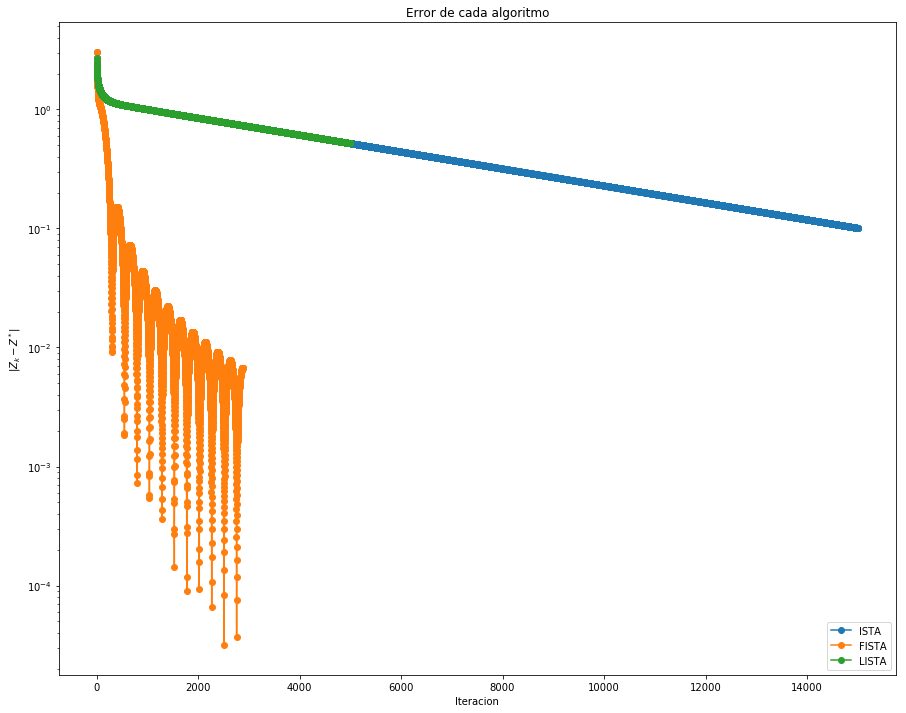

In [3]:
# Graficamos historial:
plt.title('Error de cada algoritmo')
plt.plot([la.norm(Z1[i+1]-Zopt) for i in range(len(Z1)-1)], '-o', label='ISTA')
plt.plot([la.norm(Z2[i+1]-Zopt) for i in range(len(Z2)-1)], '-o', label='FISTA')
plt.plot([la.norm(Z3[i+1]-Zopt) for i in range(len(Z3)-1)], '-o', label='LISTA')
plt.xlabel('Iteracion')
plt.ylabel('$\|Z_k - Z^*\|$')
plt.yscale('log')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [4]:
# Testeamos que funcione la backpropagation:
dWe, dS, dtheta = LISTA_bprop(Zopt, cache)
print 'dWe =', dWe
print 'dS =', dS
print 'dtheta =', dtheta

dWe = [[   88.68818416  -167.74555554   -36.88508659 ...,    55.76186673
     79.8957475     42.3599057 ]
 [  279.88812044  -529.38267592  -116.40443037 ...,   175.97703933
    252.14035906   133.68223176]
 [  277.60716783  -525.06846353  -115.45579064 ...,   174.5429117
    250.08553726   132.59278633]
 ..., 
 [ -242.21061704   458.11913839   100.73449656 ...,  -152.28766127
   -218.19815664  -115.68642424]
 [ -346.90738982   656.14346914   144.27749573 ...,  -218.11477845
   -312.51542113  -165.69247031]
 [  998.92010484 -1889.36564113  -415.44716368 ...,   628.06167798
    899.88840364   477.11160001]]
dS = [[ -15.93270776  -13.19534232    1.37333338 ...,  -18.93849163
   -25.19171632  -15.11234044]
 [ -50.28120448  -41.64255704    4.33429493 ...,  -59.76759439
   -79.50209315  -47.69112142]
 [ -49.87153416  -41.30325194    4.29889562 ...,  -59.28044235
   -78.85406531  -47.30291801]
 ..., 
 [  43.51261488   36.03684061   -3.75076496 ...,   51.72184016
    68.79971318   41.27149471]

Para testear LISTA en el contexto de [1] (sobre patches de imágenes), descargamos la database BSDS500 de Berkeley de aquí:  
http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz  
(sólo utilizamos las 500 imágenes de la subcarpeta `BSR/BSDS500/data/images/` que se juntaron en carpeta `images` de esta entrega).

In [5]:
lista_images = load_dir_images('images')  # Carga las imagenes y convierte a grayscale

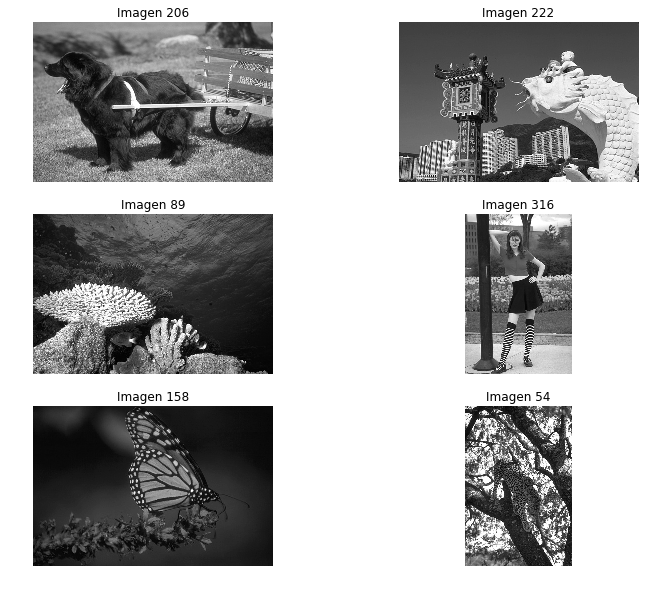

In [6]:
# Mostramos algunas imagenes aleatorias:
num_im = 6  # Debe ser par
idx = np.random.choice(range(len(lista_images)), num_im, replace=False)
for i in range(num_im):
    plt.subplot(num_im/2, 2, i+1)
    plt.imshow(lista_images[idx[i]])
    plt.axis('off')
    plt.title('Imagen %d' % idx[i])

Como sugieren en [1], extraemos `N` patches $10\times 10$ elegidos aleatoriamente de las imágenes de esta database, extraemos la media de dicho conjunto de patches, descartamos aquellos con varianza pequeña y normalizamos varianza:

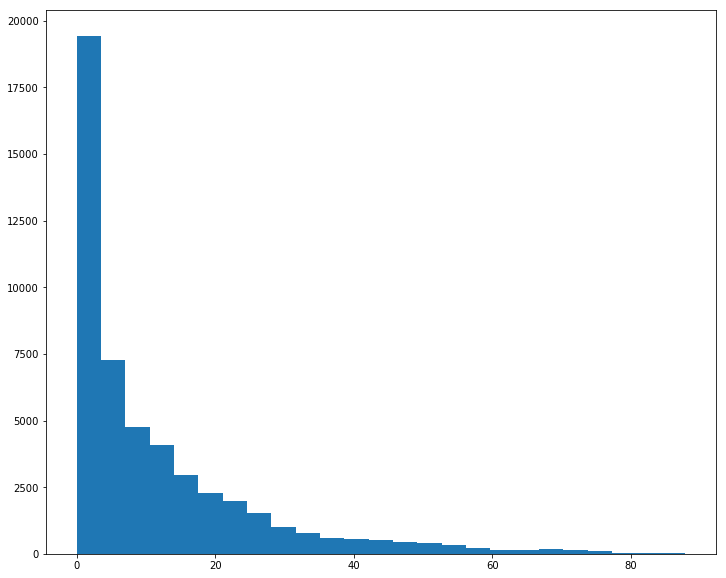

In [7]:
# Extraemos patches 10x10:
N = len(lista_images)  # Cantidad de imágenes
P = N * 100  # Cantidad total de patches
patches = np.zeros((100, P))

for k in xrange(N):
    for i in xrange(10):
        for j in xrange(10):
            patches[:,100*k+10*i+j] = lista_images[k][i:i+10,j:j+10].reshape((100,))

# Histograma de std:
patches_std = np.std(patches, axis=0)
plt.hist(patches_std, bins=25);

In [8]:
# Quitamos patches con poca varianza, centramos y normalizamos:
patches_mean = np.mean(patches, axis=0)
mask = patches_std > 15
patches = (patches[:,mask] - patches_mean[mask])/ patches_std[mask]

Total de patches: 13613
Media: [  2.54907206e-15   3.35731443e-15   2.68896017e-15 ...,   2.30926389e-16
   3.10862447e-17  -4.17860191e-16]
STD: [ 1.  1.  1. ...,  1.  1.  1.]


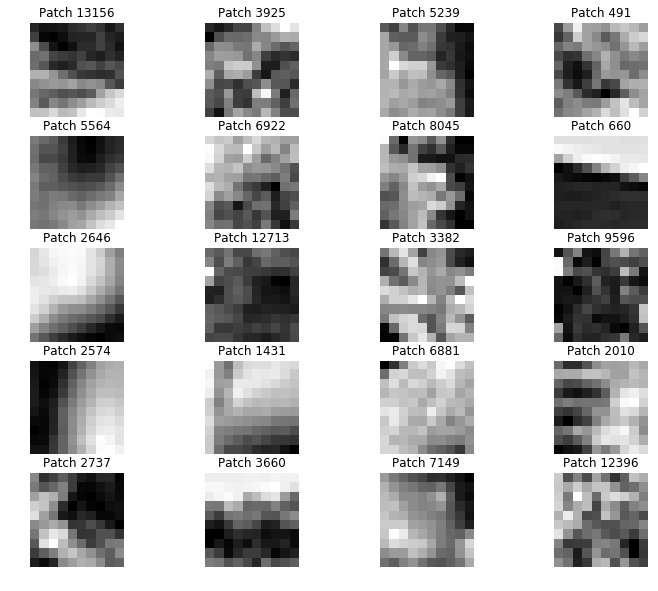

In [9]:
# Para chequear, mostramos algunos patches aleatorios:
P = patches.shape[1]
print 'Total de patches:', P
print 'Media:', np.mean(patches, axis=0)
print 'STD:', np.std(patches, axis=0)
num_im = 20  # Debe ser multiplo de 4
idx = np.random.choice(range(P), num_im, replace=False)
for i in range(num_im):
    plt.subplot(num_im/4, 4, i+1)
    plt.imshow(patches[:,idx[i]].reshape((10,10)))
    plt.axis('off')
    plt.title('Patch %d' % idx[i])

In [10]:
# Separamos aleatoriamente un 10% de patches para testear luego:
indices = np.random.permutation(P)
num_test = P / 10
training_idx, test_idx = indices[num_test:], indices[:num_test]
X_train, X_test = patches[:,training_idx], patches[:,test_idx]
print 'Patches de entrenamiento:', X_train.shape[1]
print 'Patches de test:', X_test.shape[1]

Patches de entrenamiento: 12252
Patches de test: 1361


Como se sugiere en el artículo [1] (sección 4 (Results), segundo párrafo), entrenamos diccionario de patches de la siguiente manera:
- Seleccionamos un patch $X^p$ de entrenamiento al azar
- Hallamos $Z^{*p}$ óptimo usando FISTA (en lugar de CoD como en el artículo)
- Actualizamos $W_d$ con un paso de SGD:
$$ W_d \leftarrow W_d - \eta\frac{dE_{W_d}(X^p,Z^{*p})}{dW_d} $$
donde $\eta$ es proporcional a $1/t$ ($t$ es el número de paso)
- Renormalizamos columnas de $W_d$
- Iteramos

In [11]:
# Entrenamos diccionario optimo o lo cargamos del disco uno previamente aprendido:
opcion = 'cargar'  # Sino, poner 'entrenar'

if opcion == 'cargar':
    alpha = 10.  # Parametro de sparsity
    Wd = read_csv('diccionario_alpha10.csv')
    m = Wd.shape[1]  # Tamaño de la base
    
elif opcion == 'entrenar':  # Este es el codigo usado para entrenar el dicc del csv
    m = 100  # Complete code
    alpha = 10.  # Parametro de sparsity
    lr = 10000.  # Learning rate para SGD
    Wd = np.random.randn(100,m)  # Inicializamos diccionario de patches
    # Normalizamos columnas (lo anterior las crea casi normalizadas, pero no cuesta nada):
    Wd /= np.std(Wd, axis=0)

    num_iters = 10*P  # Para usar varias veces cada patch en el entrenamiento (en promedio)
    indices = np.random.randint(P, size=num_iters)  # Para elegir patch al azar

    for t in xrange(num_iters):
        Xp = X_train[:,indices[t]]  # Extraemos patch de entrenamiento
        Zp = FISTA(Wd, Xp, alpha)[-1]  # Codigo optimo
        dWd = np.tensordot(Wd.dot(Zp)-Xp, Zp, axes=0)
        Wd -= lr/(t+1) * dWd  # SGD
        Wd /= np.std(Wd, axis=0)  # Normalizamos columnas
    
    # Salvamos en disco diccionario aprendido:
    np.savetxt("diccionario.csv", Wd, delimiter=",")

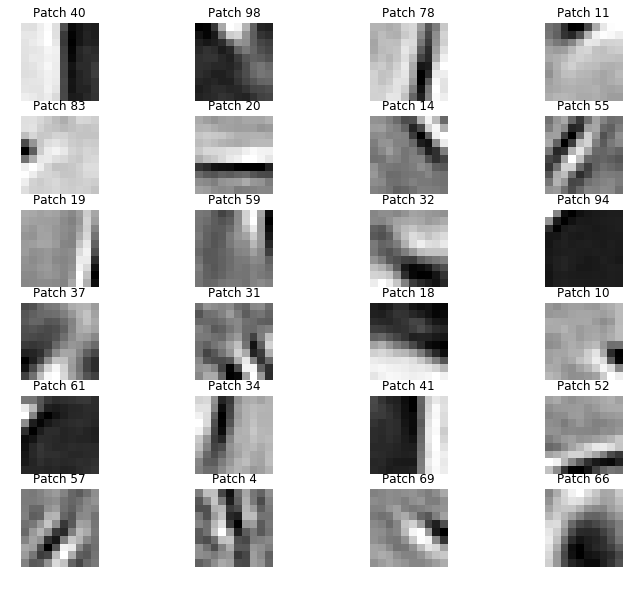

In [12]:
# Visualizamos algunos patches del diccionario aprendido:
num_im = 24  # Debe ser multiplo de 4
idx = np.random.choice(range(m), num_im, replace=False)
for i in range(num_im):
    plt.subplot(num_im/4, 4, i+1)
    plt.imshow(Wd[:,idx[i]].reshape((10,10)))
    plt.axis('off')
    plt.title('Patch %d' % idx[i])

In [18]:
# Ahora entrenamos LISTA en este diccionario:
P = X_train.shape[1]  # Cantidad de patches de entrenamiento
num_iters = 4*P  # Para usar varias veces cada patch en el entrenamiento (en promedio)
indices = np.random.randint(P, size=num_iters)  # Para elegir patch al azar
T = 3  # Cuantas iteraciones queremos hacer en LISTA
lr = {'We': 1e-4, 'S': 1e-4, 'theta': 1e-4}  # Learning rates para SGD
print 'Entrenando LISTA para T=%d:' % T

# Inicializamos parametros de LISTA (a ser entrenados):
L = np.max(la.eigh(Wd.T.dot(Wd))[0])
We = np.copy(Wd).T / L  # El que usa ISTA
S = np.eye(m) - We.dot(Wd)  # El que usa ISTA
theta = alpha/L  # El que usa ISTA

for t in xrange(num_iters):
    if t%1000 == 0:
        print 'Iteracion %d de %d' % (t, num_iters)
    Xp = X_train[:,indices[t]]  # Extraemos patch de entrenamiento
    Zp = FISTA(Wd, Xp, alpha)[-1]  # Codigo optimo
    _, cache = LISTA_fprop(Xp, We, S, theta, T)
    dWe, dS, dtheta = LISTA_bprop(Zp, cache)
    We -= lr['We']/(t+1) * dWe  # SGD
    S -= lr['S']/(t+1) * dS  # SGD
    theta -= lr['theta']/(t+1) * dtheta  # SGD
    theta = np.fmax(theta, 0)  # Para evitar que theta<0

Entrenando LISTA para T=3:
Iteracion 0 de 49008
Iteracion 1000 de 49008
Iteracion 2000 de 49008
Iteracion 3000 de 49008
Iteracion 4000 de 49008
Iteracion 5000 de 49008
Iteracion 6000 de 49008
Iteracion 7000 de 49008
Iteracion 8000 de 49008
Iteracion 9000 de 49008
Iteracion 10000 de 49008
Iteracion 11000 de 49008


KeyboardInterrupt: 

In [ ]:
# Para testear, representamos algunos patches de test
# en este diccionario usando FISTA y LISTA:
num_im = 5  # Cantidad de patches a mostrar
idx = np.random.choice(range(X_test.shape[1]), num_im, replace=False)
times_FISTA = np.zeros((num_im))  # Medimos tiempos de ejecucion
times_LISTA = np.zeros((num_im))  # Medimos tiempos de ejecucion

for i in range(num_im):
    Xp = X_test[:,idx[i]]
    
    # Corremos FISTA:
    tic = time()
    aux = FISTA(Wd, Xp, alpha, maxiter=1000)
    toc = time()
    times_FISTA[i] = toc-tic
    Zopt = aux[-1]  # Asumimos que FISTA converge al codigo optimo
    Zp_FISTA = aux[T]  # Iteracion T de FISTA
    cant_iter = len(aux) - 1  # Resultado y cantidad de iteraciones
    
    # Corremos LISTA:
    tic = time()
    Zp_LISTA = LISTA_fprop(Xp, We, S, theta, T)[0][-1]
    toc = time()
    times_LISTA[i] = toc-tic
    
    err_FISTA = np.sum((Zopt-Zp_FISTA)**2)
    err_LISTA = np.sum((Zopt-Zp_LISTA)**2)
    plt.subplot(num_im, 3, 3*i+1), plt.imshow(Xp.reshape((10,10)))
    plt.axis('off'), plt.title('Patch %d' % idx[i])
    plt.subplot(num_im, 3, 3*i+2), plt.imshow(Wd.dot(Zp_FISTA).reshape((10,10)))
    plt.axis('off'), plt.title('FISTA (%d iter, err=%f)' % (T, err_FISTA))
    plt.subplot(num_im, 3, 3*i+3), plt.imshow(Wd.dot(Zp_LISTA).reshape((10,10)))
    plt.axis('off'), plt.title('LISTA (%d iter, err=%f)' % (T, err_LISTA))